In [1]:
import os
import cv2
import numpy as np
import sys
import pickle
from optparse import OptionParser
import time
from keras_frcnn import config
import keras_frcnn.resnet as nn
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
import random
from keras.utils import plot_model
import pydot


sys.setrecursionlimit(40000)
		
# parser = OptionParser()

# parser.add_option("-p", "--path", dest="test_path", help="Path to test data.")
# parser.add_option("-n", "--num_rois", dest="num_rois",
# 				help="Number of ROIs per iteration. Higher means more memory use.", default=32)
# parser.add_option("--output_config_filename", dest="config_filename", help=
# 				"Location to read the metadata related to the training (generated when training).",
# 				default="config.pickle")
# parser.add_option("--img_output", dest="img_out_path", help="Location to output the tested data images") 

# (options, args) = parser.parse_args()
# print((options, args))
# if not options.test_path:   # if filename is not given
# 	parser.error('Error: path to test data must be specified. Pass --path to command line')


# config_output_filename = options.config_filename
config_output_filename = "model_frcnn_11.pickle"
# config_output_filename = "config.pickle"

with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)
# print("debug")
# print(C.im_size)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

# img_path = options.test_path


def format_img(img, C):
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img


class_mapping = C.class_mapping

if 'bg' not in class_mapping:
	class_mapping['bg'] = len(class_mapping)

# print("class_mapping")
# print(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}

colors ={ 	'shoe'	 :	(0, 0,	255), 
			'slipper':	(255,	0,	0),
			'sandal' :	(0	, 255,	0),
			'bg'	 :	(0	,	0,	0)
		}

class_to_color = {class_mapping[v]: colors[class_mapping[v]] for index, v in enumerate(class_mapping)}

# C.num_rois = int(options.num_rois)
C.num_rois = 32

if K.image_dim_ordering() == 'th':
	input_shape_img = (3, None, None)
	input_shape_features = (1024, None, None)
else:
	input_shape_img = (None, None, 3)
	input_shape_features = (None, None, 1024)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')


# plot_model(model_classifier, to_file='model.png')  # outputed picture
# print("outputed")

# get the symbolic outputs of each "key" layer (we gave them unique names).
model_classifier_layer_dict = dict([(layer.name, layer) for layer in model_classifier.layers])
model_rpn_layer_dict = dict([(layer.name, layer) for layer in model_rpn.layers])


Using TensorFlow backend.


In [2]:
model_rpn_layer_dict
# for a in model_rpn_layer_dict:
#     print(a)

{'activation_1': <keras.layers.core.Activation at 0x11a2d4128>,
 'activation_10': <keras.layers.core.Activation at 0x11afcaeb8>,
 'activation_11': <keras.layers.core.Activation at 0x11b016d30>,
 'activation_12': <keras.layers.core.Activation at 0x11b089d30>,
 'activation_13': <keras.layers.core.Activation at 0x11b162be0>,
 'activation_14': <keras.layers.core.Activation at 0x11b1c1c50>,
 'activation_15': <keras.layers.core.Activation at 0x11b3375c0>,
 'activation_16': <keras.layers.core.Activation at 0x11b398b38>,
 'activation_17': <keras.layers.core.Activation at 0x11b3e5c88>,
 'activation_18': <keras.layers.core.Activation at 0x11b4510f0>,
 'activation_19': <keras.layers.core.Activation at 0x11b4c4a20>,
 'activation_2': <keras.layers.core.Activation at 0x11a902fd0>,
 'activation_20': <keras.layers.core.Activation at 0x11b639710>,
 'activation_21': <keras.layers.core.Activation at 0x11b68fe80>,
 'activation_22': <keras.layers.core.Activation at 0x11b7037f0>,
 'activation_23': <keras.la

In [3]:
for i, layer in enumerate(model_rpn.layers):
    print(i, layer.name)

0 input_1
1 zero_padding2d_1
2 conv1
3 bn_conv1
4 activation_1
5 max_pooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 bn2a_branch2b
11 activation_3
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_1
17 activation_4
18 res2b_branch2a
19 bn2b_branch2a
20 activation_5
21 res2b_branch2b
22 bn2b_branch2b
23 activation_6
24 res2b_branch2c
25 bn2b_branch2c
26 add_2
27 activation_7
28 res2c_branch2a
29 bn2c_branch2a
30 activation_8
31 res2c_branch2b
32 bn2c_branch2b
33 activation_9
34 res2c_branch2c
35 bn2c_branch2c
36 add_3
37 activation_10
38 res3a_branch2a
39 bn3a_branch2a
40 activation_11
41 res3a_branch2b
42 bn3a_branch2b
43 activation_12
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_4
49 activation_13
50 res3b_branch2a
51 bn3b_branch2a
52 activation_14
53 res3b_branch2b
54 bn3b_branch2b
55 activation_15
56 res3b_branch2c
57 bn3b_branch2c
58 add_5
59 activation_16
60 res3c_branch2a
61 bn3c_branch2a
62 ac

In [4]:
model_rpn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472                                         
____________________________________________________________________________________________________
bn_conv1 (FixedBatchNormalizatio (None, None, None, 64 256                                          
___________________________________________________________________________________________

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
fig_size  = np.array([24,18])
# fig_size[0] = 12
# fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [6]:
# input img
fileName= "1.png"
#prepare input picture
im = cv2.imread(fileName)
if im is None:
	print("no image file selected")
# im=cv2.resize(im, (56,56))
imNP = np.asarray(im)
a= [imNP.reshape(-1,imNP.shape[0],imNP.shape[1],imNP.shape[2]), 0]

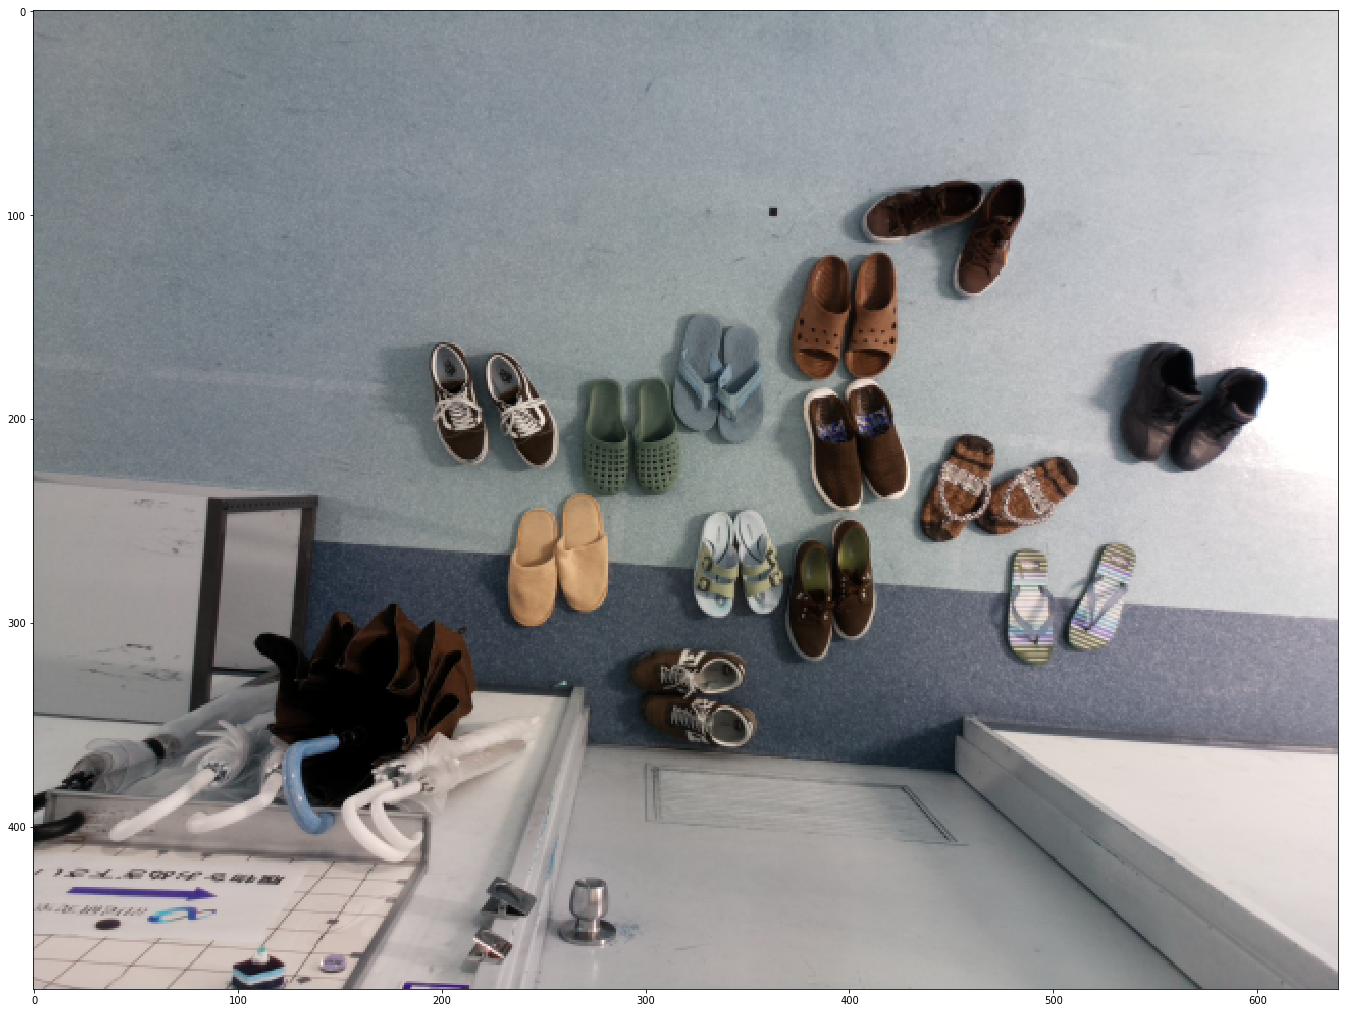

In [7]:
plt.imshow(im)

The second dimension tells us how many convolutions do we have: (1, 30, 40, 1024) (30 convolutions)
(1, 30, 40, 1024)


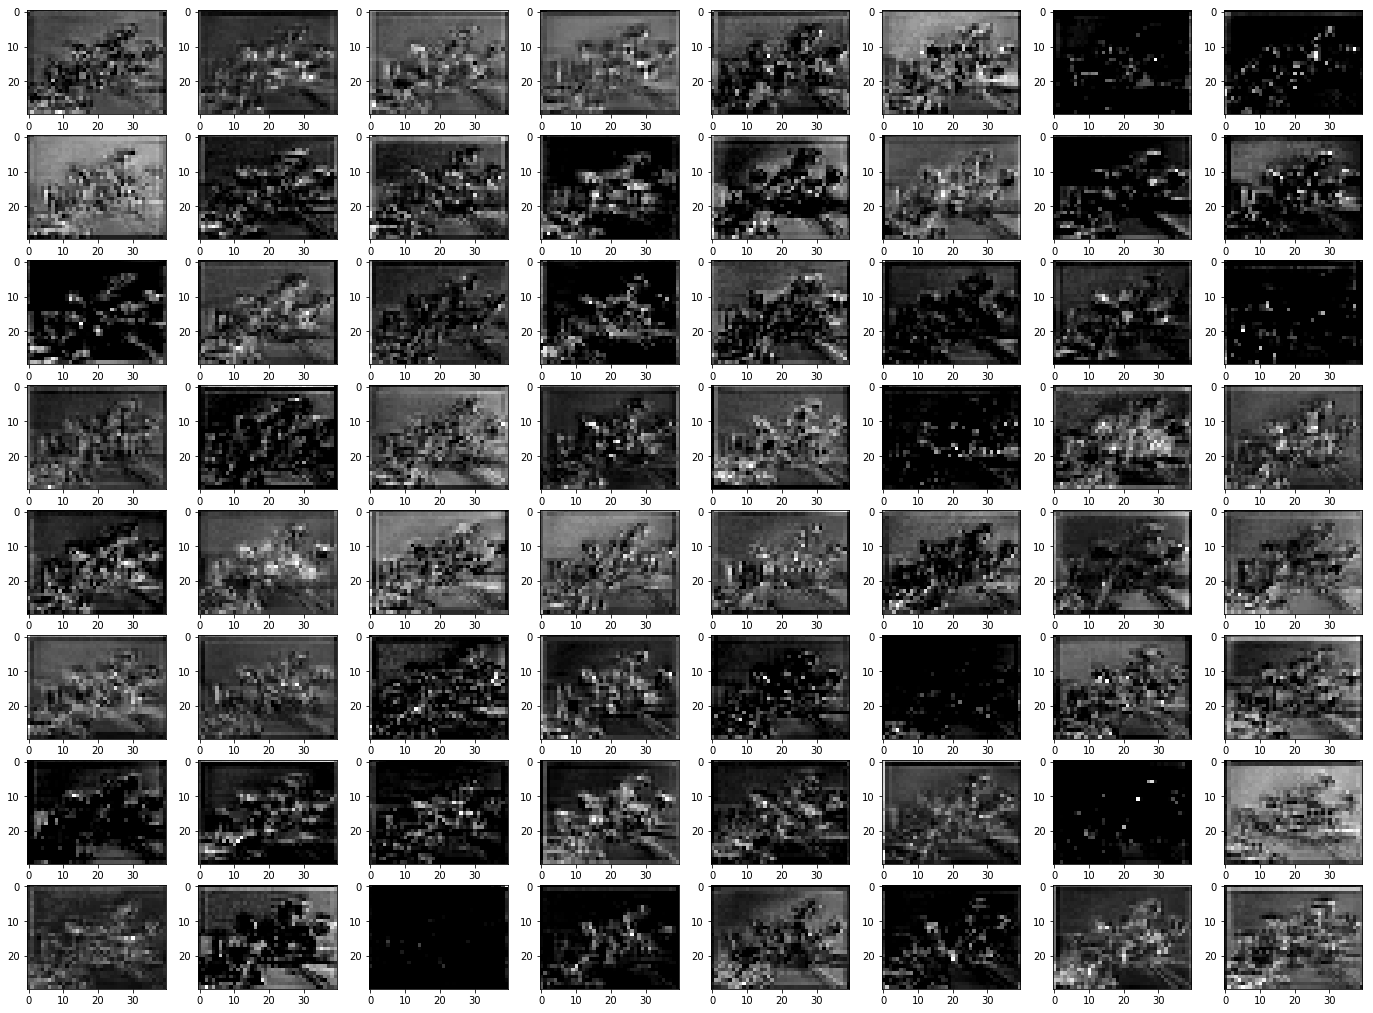

In [8]:


# layer_output = K.function([model_rpn.layers[0].input, K.learning_phase()], [model_rpn_layer_dict['rpn_conv1']])
indeex = 141
layer_output = K.function([model_rpn.layers[0].input, K.learning_phase()], [model_rpn.layers[indeex].output])
layer_output = layer_output(a)[0]

print('The second dimension tells us how many convolutions do we have: %s (%d convolutions)' % (str(layer_output.shape),layer_output.shape[1]))
print(layer_output.shape)
numberConvolution=layer_output.shape[3]
b= int(numberConvolution/8)
a= int(numberConvolution/b)

i=1
fig = plt.figure() 
fig.canvas.set_window_title('My Window Title') 
# print("layer_output =")
# print(layer_output.shape)
# one_filter_output = np.rollaxis(layer_output, 3)[0]
# plt.imshow(one_filter_output[0],'gray')

for onePic in np.rollaxis(layer_output, 3):
#     if filterNum is 1:
#         plt.subplot(2, 1, 1)
#         plt.imshow(onePic[0], 'gray')
#         continue    
#     if filterNum is 2:
#         plt.subplot(2, 1, 2)
#         plt.imshow(onePic[0], 'gray')
#         continue
    if i > 64:
        break
    
    plt.subplot(8, 8, i)
    plt.imshow(onePic[0], 'gray')
    i= i+1
    
#     plt.imshow(onePic[0], 'gray')
#     onePic = onePic.reshape(layer_output.shape[1],layer_output.shape[2])
#     plt.subplot(a,b, i)
#         plt.imshow(onePic,'gray')

    
#     plt.xticks([]),plt.yticks([])
#     i=i+1

    
plt.show()
